# Neural Networks for Image De-noising
- Understand how multi-layer neural networks function.
- Learn about backpropagation and gradient descent algorithms.
fsd
## Theory

Assume the noisy image can be written as a matrix $P_{i}$ where each element represents the pixel intensity of the $i$ th pixel. The goal is to train a neural network $f(P; K)$ where $K$ is the known convolution kernel to output a denoised image $Q_{i} = f(P; K)$. The nodes between the inputs and the outputs are the 'hidden nodes'. All nodes have a value between 0 and 1.

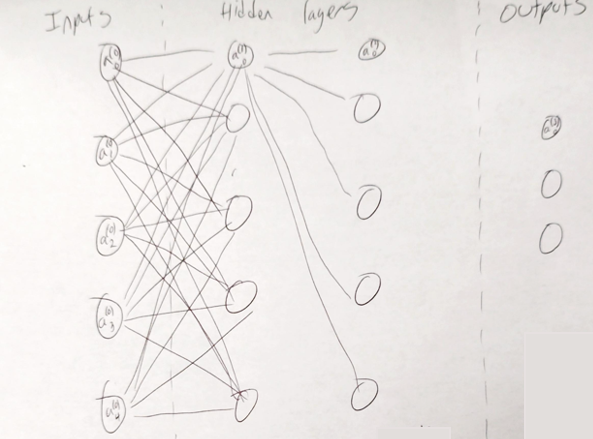

The node $a^{(1)}_0$ will have its value computed from a sum of the weighted inputs from the first layer.
$$a^{(1)}_0 = \sigma(b_0+\sum_{i} w_{i}P_{i})$$
Where $\sigma$ is the normalisation function given by $\sigma(x) = \frac{1}{1 + e^{-x}}$. $w_{i}$ are the weights associated with each input pixel $P_{i}$, $b_0$ is the bias term.

The first next layer of hidden nodes can be calculated from:

$$\mathbf{a}^{(i+1)} = \sigma(W^{(i)}\mathbf{a}^{(i)} + \mathbf{b}^{(i)})$$
 
Where $W^{(i)}$ is the weight matrix and $\mathbf{b}^{(i)}$ is the bias vector which transforms the $i$ th layer into the $i+1$ th layer. The values of $W^{(i)}$ and $\mathbf{b}^{(i)}$ are learned during training.

## Gradient Descent

The cost function measures the success of the machine learning algorithm one way it could be defined is as follows:
$$C(\mathbf{w}) = \sum_i (\hat{p}_i - p_i)^2$$
Where $\hat{p}_i$ is the estimated state from the MLP and $p_i$ is the known state. The vector $\mathbf{w}$ contains all the weights in the network. This sum is small when the network is close to being "correct".

Using gradient decent can be used to find a local minima, an optimized solution. The vector $-\Delta C(\mathbf{w})$ points in the direction of steepest decent.


## Generate test data

In [108]:
import torch
import matplotlib.pyplot as plt
from ImageDebluring import *
from torchvision import transforms

def step_function(period=2.0, amplitude=0.8, y_intercept=0.0, steps=1000, x_offset=0.0):
    s = steps
    xs = torch.linspace(-5, 5, steps=s)
    ys = amplitude * torch.heaviside(torch.sin(2 * torch.pi * (xs + x_offset) / period), torch.zeros_like(xs)) + y_intercept
    return ys

def generate_random_function(vary_period = False, vary_amplitude = False, vary_y_intercept = False, vary_x_offset = False):
    if vary_period:
        period = torch.rand(1, generator=rng).item()*3 + 5
    else:
        period = 5
    if vary_amplitude:
        amplitude = torch.rand(1, generator=rng).item() * 0.9 + 0.1
    else:
        amplitude = 0.3
    if vary_y_intercept:
        y_intercept = torch.rand(1, generator=rng).item() * 0.3
    else:
        y_intercept = 0.3
    if vary_x_offset:
        x_offset = torch.rand(1, generator=rng).item() * 2*torch.pi
    else:
        x_offset = 0.0
    return step_function(period, amplitude, y_intercept, x_offset=x_offset).unsqueeze(0).unsqueeze(0)

def generate_test_data(amount = 10000, noise_scale = 5000, blur_std = 61, kernel_size=20, vary_period = False, vary_amplitude = False, vary_y_intercept = False, vary_x_offset = False):
    y = []
    X = []
    for i in range (amount):
        data = generate_random_function(vary_period = vary_period, vary_amplitude = vary_amplitude, vary_y_intercept = vary_y_intercept, vary_x_offset = vary_x_offset)
        degraded_data = degrade_image_1D(data, noise_scale=noise_scale, kernel=gaussian_normalised_kernel_1D(blur_std, kernel_size), padding_mode='replicate')
        X.append(degraded_data.squeeze())
        y.append(data.squeeze())
        
    # Make tensors
    X = torch.stack(X)
    y = torch.stack(y)
    return X, y

## Preparing the data

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def prep_data(X, y):
    # Create training and testing sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the data
    scaler_x= MinMaxScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)
    
    # Convert to PyTorch tensors
    X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32).reshape(len(X_train_scaled), -1)
    X_test_scaled  = torch.tensor(X_test_scaled,  dtype=torch.float32).reshape(len(X_test_scaled),  -1)
    y_train_scaled = torch.tensor(y_train_scaled, dtype=torch.float32).reshape(len(y_train_scaled), -1)
    y_test_scaled  = torch.tensor(y_test_scaled,  dtype=torch.float32).reshape(len(y_test_scaled),  -1)
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_x, scaler_y

## Defining the MLP model
- input size for this dataset is 1000 (number of points in the 1D signal)
- hidden size can be adjusted, start with 128
- output size is also 1000 (number of points in the 1D signal)
- requires_grad=True to enable backpropagation

## Forward Pass
- Linear transformation of inputs $z^{(1)} = XW^{(1)} + b^{(1)}$
- Apply activation function $a^{(1)} = \sigma(z^{(1)})$ to node values
- Linear transformation of hidden layer $z^{(2)} = a^{(1)}W^{(2)} + b^{(2)}$
- Apply activation function $a^{(2)} = \sigma(z^{(2)})$ to get final output

## Backpropagation
- `backward` updates the weights and the baises
- `epochs` the number of times the model sees the entire dataset
- `lr` hyperparameter that controls the step size for weighted updates
- `loss` the MSE


In [110]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, m = 1):
        self.W1 = torch.randn(input_size, hidden_size, requires_grad=True) * m
        self.b1 = torch.randn(1, hidden_size, requires_grad=True) * m
        self.W2 = torch.randn(hidden_size, output_size, requires_grad=True) * m
        self.b2 = torch.randn(1, output_size, requires_grad=True) * m

    def forward(self, X):
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.a1 = torch.sigmoid(self.z1) # applies sigmoid activation function
        self.z2 = torch.matmul(self.a1, self.W2) + self.b2
        self.a2 = torch.sigmoid(self.z2) 
        return self.a2
    
    def backward(self,X,y,output,lr=0.01):
        m = X.shape[0]
        dz2 = output - y
        dW2 = torch.matmul(self.a1.T, dz2)
        db2 = torch.sum(dz2, axis=0)/m
        
        da1 = torch.matmul(dz2, self.W2.T)
        dz1 = da1*(self.a1*(1-self.a1))
        dW1=torch.matmul(X.T,dz1)/m
        db1 = torch.sum(dz1, axis=0) / m
        
        with torch.no_grad():
            self.W1 -= lr * dW1
            self.b1 -= lr * db1
            self.W2 -= lr * dW2
            self.b2 -= lr * db2
            
    def train(self, X, y, epochs = 1000, lr = 0.01):
        losses = []
        print("\nlosses")
        for i in range(epochs):
            output = self.forward(X)
            # Compute loss using MSE
            loss = torch.mean((output - y)**2)
            losses.append(loss.item())
            # Update weights
            self.backward(X, y, output, lr)
            
            print(f'\rEpoch {i}, Loss: {loss.item()}', end='', flush=True)
        return losses
        

## Initialize model

In [111]:
def plot_losses(losses):
    fig, ax = plt.subplots()
    ax.scatter(range(len(losses)),  losses)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def train_model(X_train_scaled, y_train_scaled, hidden_size = 128, epochs = 100, lr = 0.01):
    input_size = X_train_scaled.shape[1]
    model = MLP(input_size, hidden_size, input_size)
    losses = model.train(X_train_scaled, y_train_scaled, epochs=epochs, lr=lr)
    plot_losses(losses)
    return model

In [112]:
import seaborn as sns
import numpy as np

def test_model(amount = 10000, noise_scale = 5000, blur_std = 61, kernel_size=20, epochs=100, lr=0.01, hidden_size=128, vary_period=False, vary_amplitude=False, vary_y_intercept=False, vary_x_offset=False, X = None, y = None):
    global rng
    rng = torch.Generator().manual_seed(1)
    if X is None or y is None:
        print("Generating data...", end='', flush=True)
        X, y = generate_test_data(amount = amount, noise_scale = noise_scale, blur_std = blur_std, kernel_size=kernel_size, vary_period = vary_period, vary_amplitude = vary_amplitude, vary_y_intercept = vary_y_intercept, vary_x_offset = vary_x_offset)
        print("\nData generated", end='', flush=True)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_x, scaler_y = prep_data(X, y)
    print("\nData preppared", end='', flush=True)
    model = train_model(X_train_scaled, y_train_scaled, epochs = epochs, lr = lr, hidden_size = hidden_size)
    print("\nModel trained", end='', flush=True)
    # Select 4 waves to vosialise
    fig, axs = plt.subplots(4,2, figsize=(8,15))
    axs = axs.flatten()
    y_pred_scaled = model.forward(X_test_scaled)

    y_pred = scaler_y.inverse_transform(y_pred_scaled.detach().numpy())
    X_test = scaler_x.inverse_transform(X_test_scaled.detach().numpy())
    y_test = scaler_y.inverse_transform(y_test_scaled.detach().numpy())

    for i in range (8):
        sns.lineplot(x=np.arange(len(y_pred[i])), y=y_pred[i], ax=axs[i], label='predicted', alpha = 0.7)
        sns.lineplot(x=np.arange(len(X_test[i])), y=X_test[i], ax=axs[i], label='degraded', alpha = 0.7)
        sns.lineplot(x=np.arange(len(y_test[i])), y=y_test[i], ax=axs[i], label='original', alpha = 0.7)
        axs[i].legend()
    print("\nDone!")

Generating data...


Data generated
Data preppared
losses
Epoch 9, Loss: 1.2177383545974862e-09
Model trained
Done!


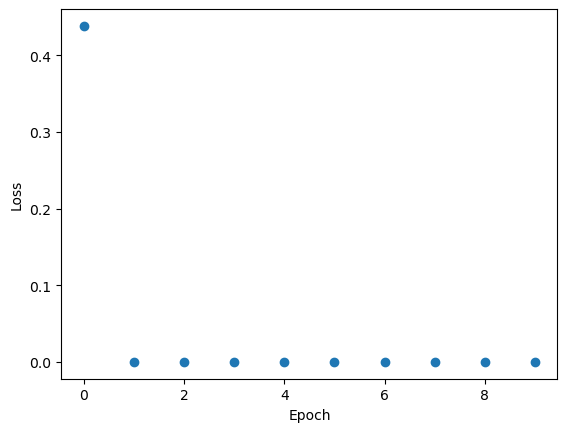

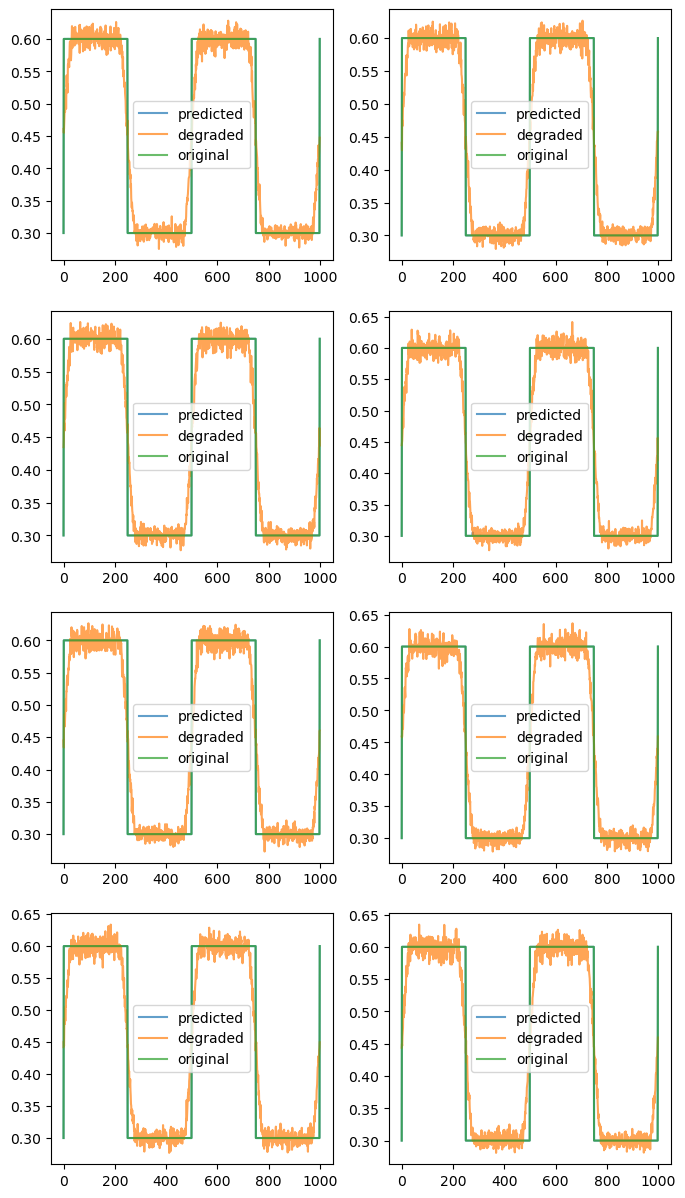

In [113]:
test_model(epochs=10)


Data preppared
losses
Epoch 29, Loss: 0.43481647968292236
Model trained
Done!


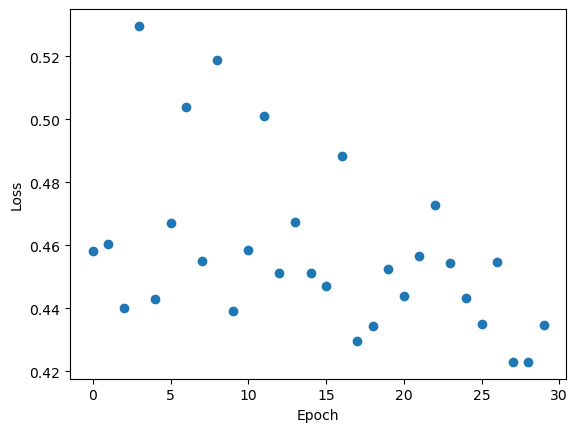

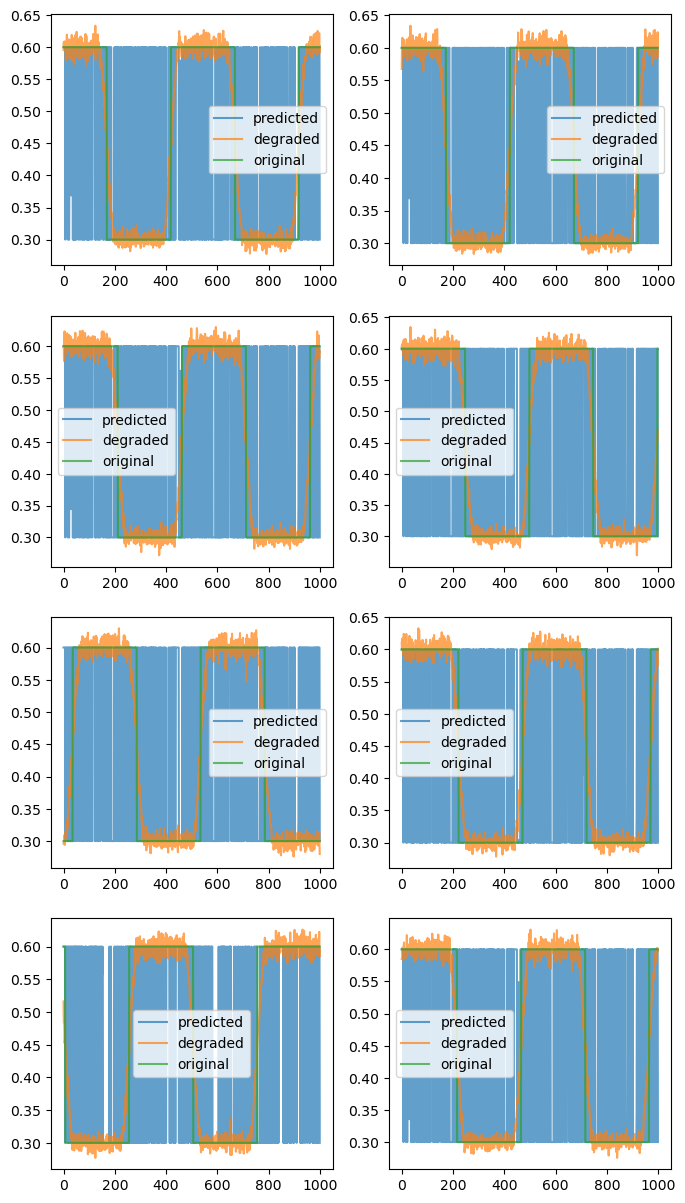

In [114]:
X, y = generate_test_data(amount = 1000, noise_scale = 5000, blur_std = 61, kernel_size=20, vary_x_offset=True)
test_model(X = X, y = y, hidden_size=256, epochs = 30, lr = 0.05)


Data preppared
losses
Epoch 49, Loss: 0.0019419251475483183
Model trained
Done!


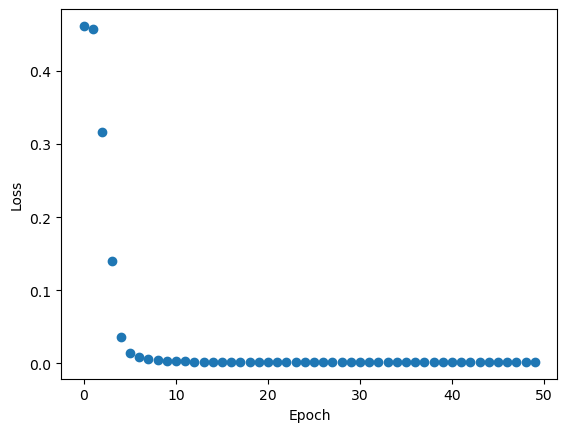

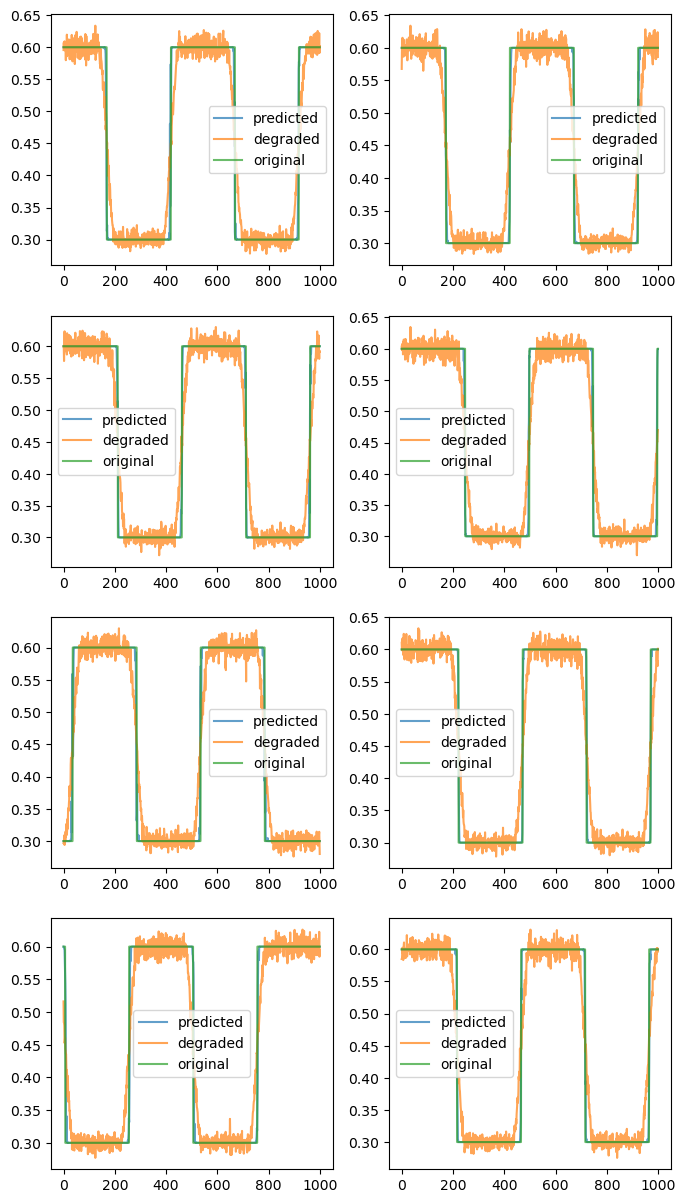

In [115]:
test_model(X = X, y = y, hidden_size=256, epochs = 50, lr = 0.005)


Data preppared
losses
Epoch 49, Loss: 0.0040606306865811355
Model trained
Done!


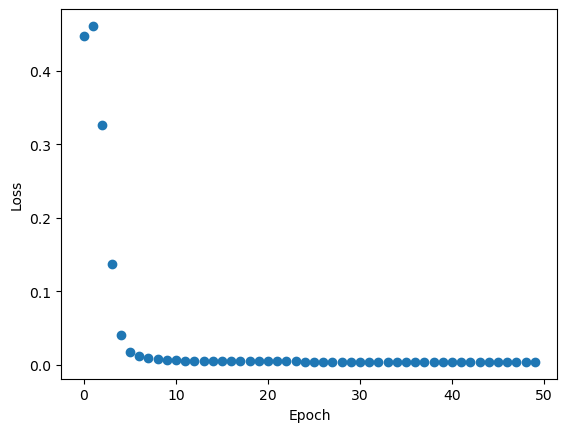

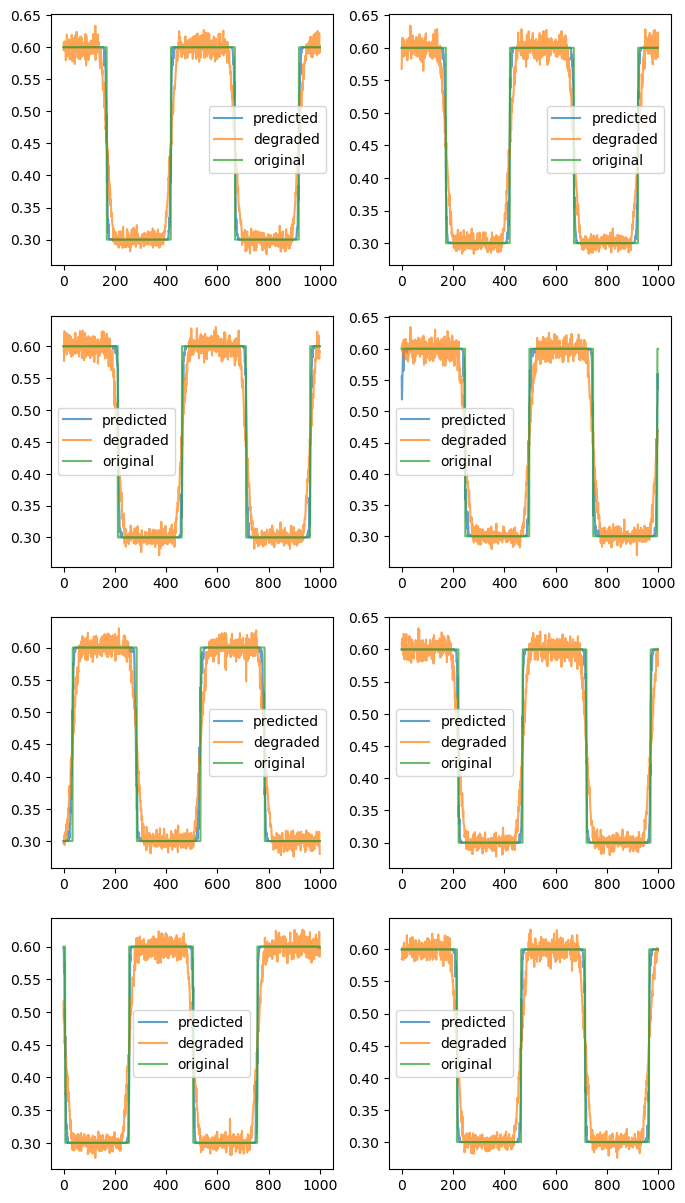

In [116]:
test_model(X=X, y=y, hidden_size=128, epochs = 50, lr = 0.005)

Generating data...
Data generated
Data preppared
losses
Epoch 49, Loss: 0.030899826437234884
Model trained
Done!


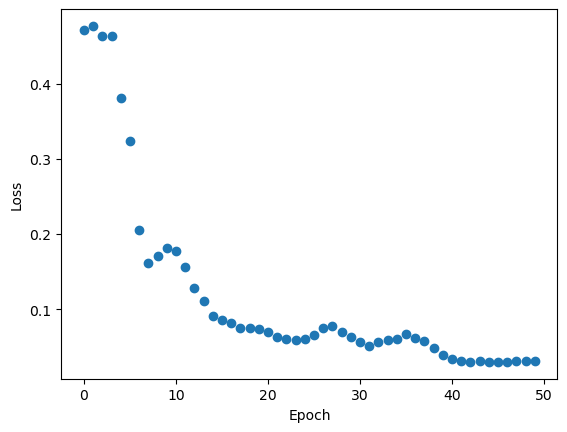

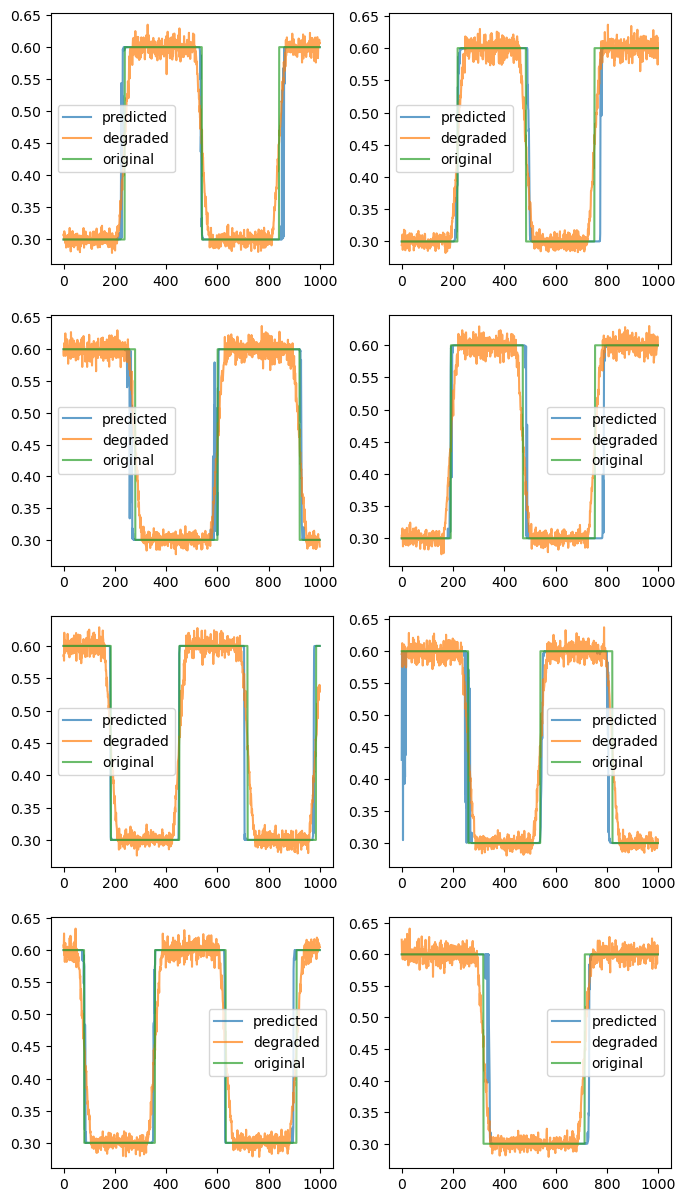

In [118]:
test_model(vary_x_offset = True, vary_period=True, hidden_size=256, epochs = 50, lr = 0.005)

Generating data...
Data generated
Data preppared
losses
Epoch 199, Loss: 0.016815792769193652
Model trained
Done!


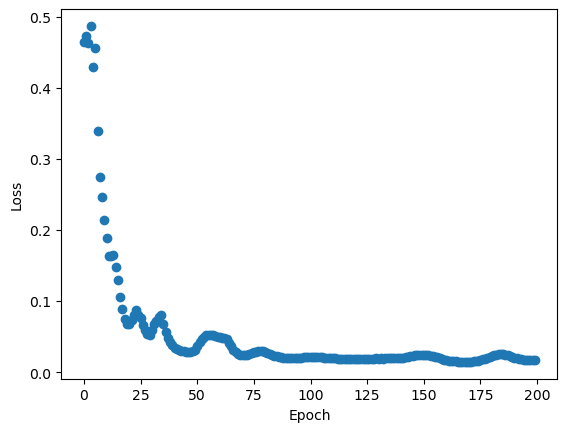

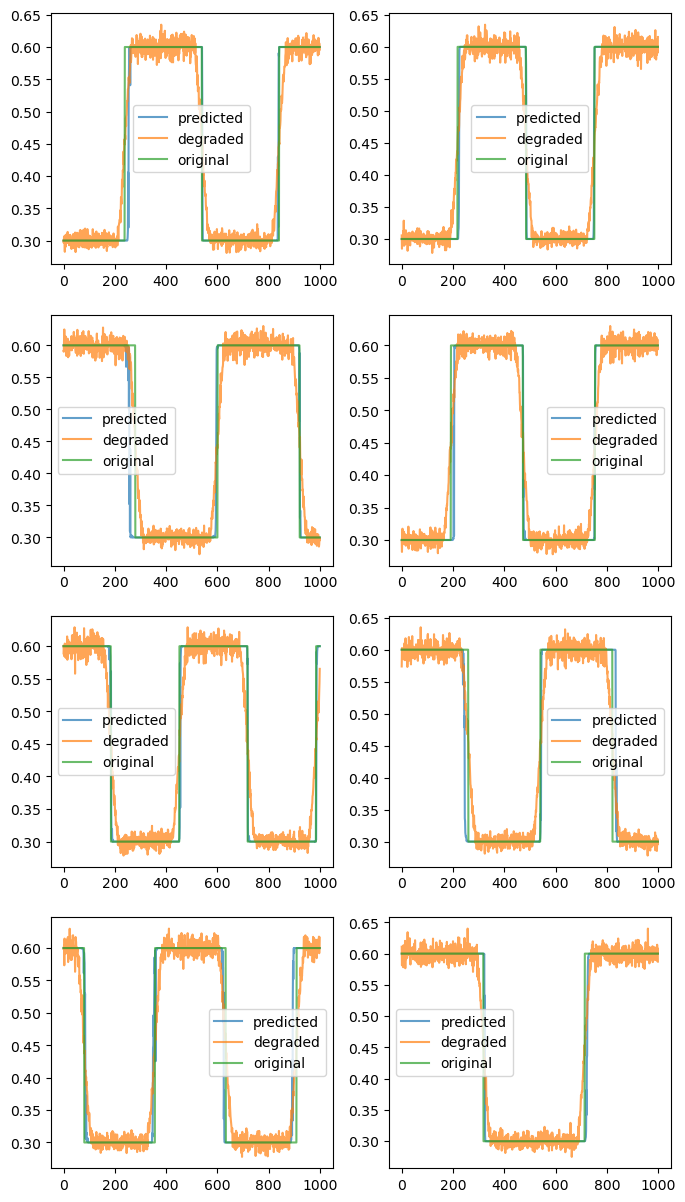

In [117]:
test_model(vary_x_offset = True, vary_period=True, hidden_size=256, epochs = 200, lr = 0.005)

Generating data...


Data generated
Data preppared
losses
Epoch 199, Loss: 0.058668453246355064
Model trained
Done!


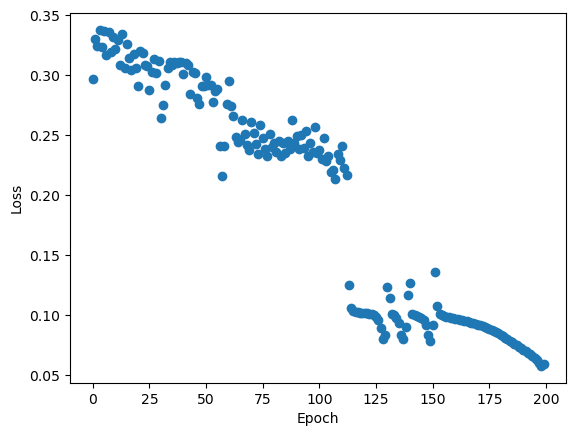

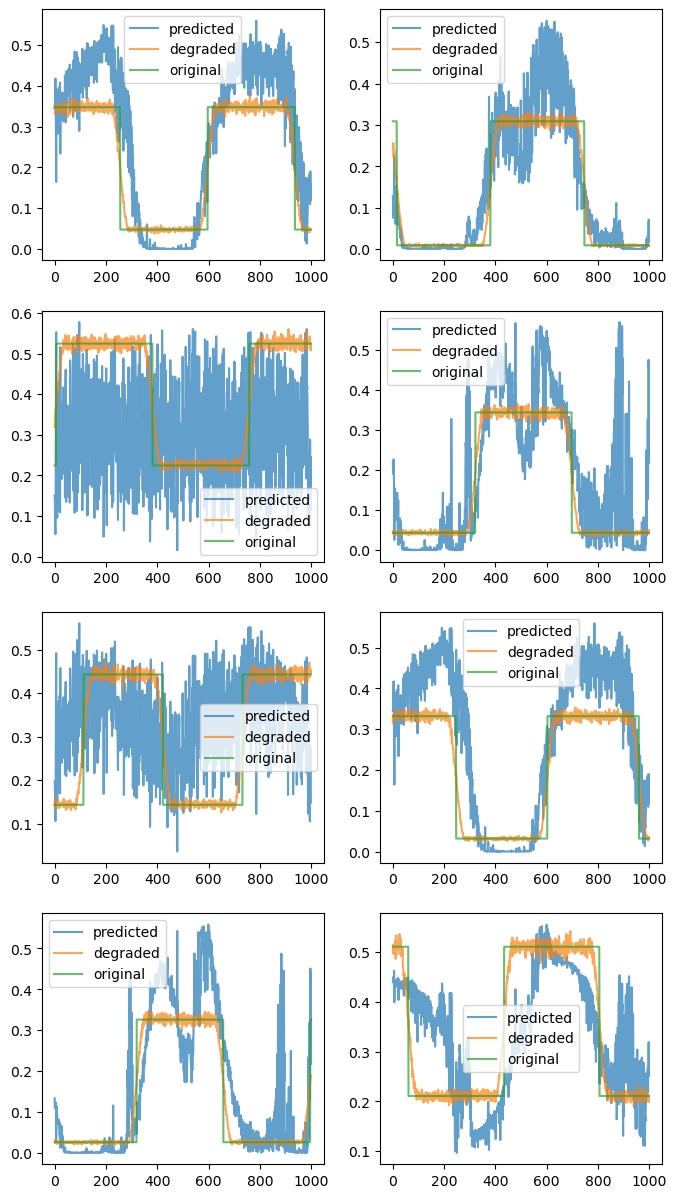

In [119]:
test_model(vary_x_offset = True, vary_period=True, vary_y_intercept=True, hidden_size=256, epochs = 200, lr = 0.005)

Generating data...
Data generated
Data preppared
losses
Epoch 499, Loss: 0.20956066250801086
Model trained
Done!


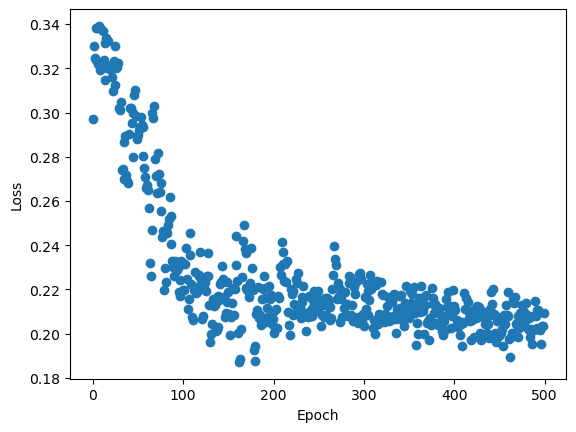

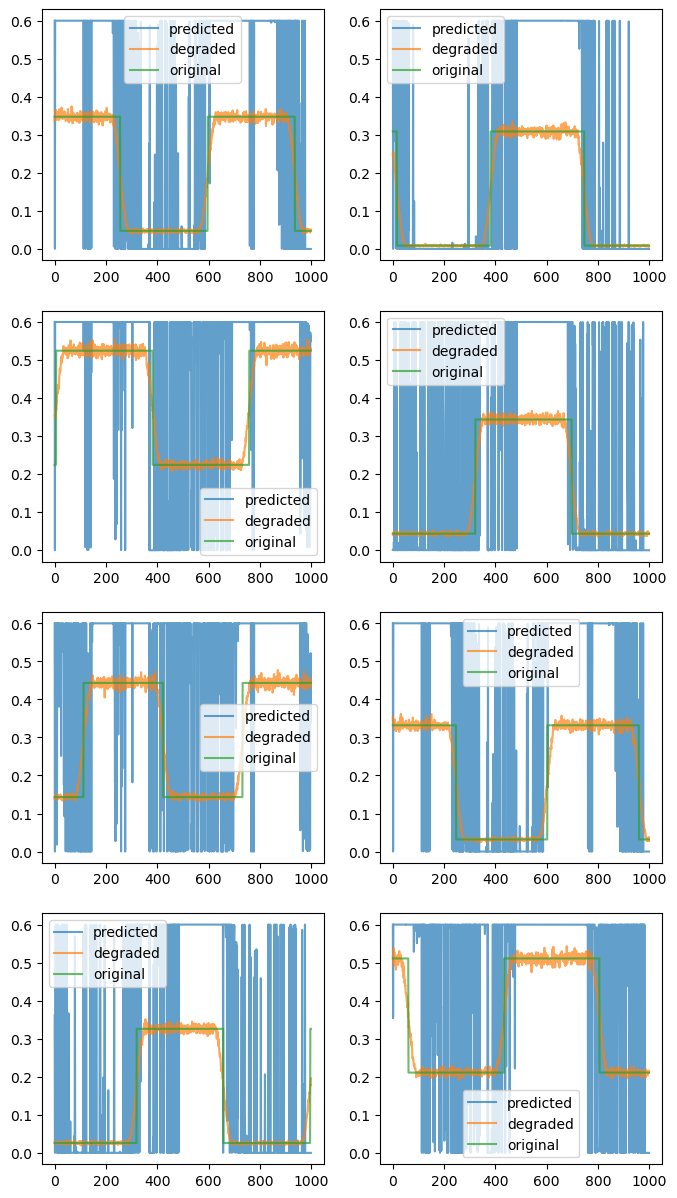

In [120]:
test_model(vary_x_offset = True, vary_period=True, vary_y_intercept=True, hidden_size=256, epochs = 500, lr = 0.005)